In [1]:
# A small price to pay to have notebook directory! 
import sys
import os

# Add the root directory to the Python environment
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from src.graph import create_graph, create_graph_by_symbol, draw_labeled_multigraph
import os
from ast import literal_eval
import subprocess
from collections import Counter
import itertools as it

In [3]:
df = pd.read_csv('/workspaces/uniswap-v3-crawler/data/snapshots/snapshot_22358551.csv.gz')
df = df.sort_values('liquidity')
df['other'] = df['other'].apply(literal_eval)
df.head()

,createdAtBlockNumber,id,token0Price,token1Price,liquidity,totalValueLockedUSD,other,token0_decimals,token0_id,token0_name,token0_symbol,token1_decimals,token1_id,token1_name,token1_symbol,version
12070,11502580,0xbef6c1b91f2e4e81d227a4467de48001f5530ea5,0.000000e+00,2.000000e+18,1.414214e-09,6669.698059,"{'totalSupply': '0', 'reserveETH': '2.00000000...",18,0x11e54e794675622dcf9b2c4bb0bff8bedbdf89aa,MileVerse,MVC,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v2
6778,10425884,0x36bdc38902713e37a622180187354c77b718ac89,0.000000e+00,2.656943e+18,1.630013e-09,8998.187079,"{'totalSupply': '0', 'reserveETH': '2.65694292...",18,0x0423276a1da214b094d54386a1fb8489a9d32730,kusama,KSM,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v2
1734,12380445,0xb8784a63baa63ca26b40debf916540c6ee3291e6,0.000000e+00,2.993400e+18,1.730145e-09,12276.424888,"{'totalSupply': '0', 'reserveETH': '2.99340000...",18,0x31de994710629896b41e7415c89bd5ba0849f15b,Oiler Network,OIL,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v2
12013,12600586,0x33aa84cf1f0a227bd37cee5d8a58afadb8357e2a,0.000000e+00,3.320000e+18,1.822087e-09,6699.447171,"{'totalSupply': '0', 'reserveETH': '3.32000000...",18,0xbe1de9c82bba374389d5ea048089f472d7035a7f,SpaceX,SpaceX,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v2
1087,12437848,0x457fb8deb24e557f3d88ff1ce4f4c0c65d062cf9,4.000000e+18,0.000000e+00,2.000000e-09,14036.570506,"{'totalSupply': '0', 'reserveETH': '4.00000000...",18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xf31cdd92aeb9fb5c24bb3107ab4361d9d06341c6,SHIBASWAP,SHIBASWAP,v2


In [4]:
df[df['liquidity'].apply(float) == 0].version.value_counts()
num_liquid_0_pools = df[df['liquidity'].apply(float) == 0].shape[0]
print(f"Number of pools with liquidity 0: {num_liquid_0_pools}")

Number of pools with liquidity 0: 0


## Prepare the graph

### Liquidity 0
First we remove pools with liquidity 0.

Copilot:
 * A pool with zero liquidity indicates that there are no assets available for trading in that pool.
 * To have liquidity of 0, all assets must be removed from the pool or it must be initialized with no assets.

In [5]:
def extract_fee_tier(row):
    if row['version'] in ['v3', 'v4']:
        return int(row['other'].get('feeTier', 0))
    elif row['version'] == 'v2':
        return 3000
    return None

if 'feeTier' not in df.columns:
    df['feeTier'] = df.apply(extract_fee_tier, axis=1)

df.tail()

,createdAtBlockNumber,id,token0Price,token1Price,liquidity,totalValueLockedUSD,other,token0_decimals,token0_id,token0_name,token0_symbol,token1_decimals,token1_id,token1_name,token1_symbol,version,feeTier
17773,17418871,0x280429af7a71443652d90e1f1630ea88e3d26729,9.908435e-05,1.009241e+04,1.110661e+32,1.828238,"{'feeTier': '10000', 'sqrtPrice': '79593398205...",18,0x1cf8c331aa4dd6266780d8a1610387f5f178f901,SANO,SANO,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v3,10000
17217,17333321,0xb0cdd93e28abf570265f271175b02877e89999f4,4.985930e-01,2.005644e+00,1.053823e+33,7.455343,"{'feeTier': '3000', 'sqrtPrice': '112203526612...",18,0x4244ffc94e03b5aa0b4ce9897088b7ba87a61cf0,buy,buy,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v3,3000
16824,16750148,0x5d342c10657fd352ceb4d7cd23504580b950fb2f,9.984979e+14,1.000000e-15,1.899363e+33,16.120015,"{'feeTier': '500', 'sqrtPrice': '2507298298773...",18,0x7c6b16b538cda7263528fe95cc8dfda7b9532897,I,I,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v3,500
17504,12728694,0x68f5d4009f9001c8d00ced56c1e90702c998cc95,5.989519e-03,1.669583e+02,1.907855e+33,3.656844,"{'feeTier': '500', 'sqrtPrice': '1023725682415...",18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdba6c02329d5f84856b32f401d4c5e3009e75eb3,BITCOIN BANK AMERICA COIN,BBAC,v3,500
11084,21623124,0xe890321c5ccf426ebddf017b17a0ce1af3fec2dc,1.020179e+00,9.802200e-01,1.833394e+34,11569.872434,"{'feeTier': '10000', 'sqrtPrice': '78440683682...",18,0x1d5ae334d760032417691bb1e33601b08e251aee,Wrapped CAW,WCAW,18,0xf3b9569f82b18aef890de263b84189bd33ebe452,A Hunters Dream,CAW,v3,10000


In [6]:
df[df['feeTier'] == 0]

,createdAtBlockNumber,id,token0Price,token1Price,liquidity,totalValueLockedUSD,other,token0_decimals,token0_id,token0_name,token0_symbol,token1_decimals,token1_id,token1_name,token1_symbol,version,feeTier
18399,22210790,0xdc6cb2e032b7fb675c931b9845576d236e1b72c34631...,9.997001e-01,1.000300e+00,6.487435e+06,1.297487e+01,"{'feeTier': '0', 'sqrtPrice': '792400470357421...",6,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,v4,0
18956,21819095,0x811a9d9ae89f0bd308e8c2d5f66e98974069f8b9e239...,4.587896e-02,2.179648e+01,9.000438e+06,4.131838e-03,"{'feeTier': '0', 'sqrtPrice': '369890162132435...",18,0x0000000000000000000000000000000000000000,Ethereum,ETH,6,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,v4,0
15699,22118807,0x1050b5f74ebd38e464dc3f83ea7bab97d6107b4e433f...,1.000000e-12,1.000000e+12,7.421532e+09,2.774625e+02,"{'feeTier': '0', 'sqrtPrice': '792281625142643...",18,0x7751e2f4b8ae93ef6b79d86419d42fe3295a4559,Wrapped USDL,wUSDL,6,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,v4,0
18469,22178329,0x5a58e252da5c25a2e2e2c69d63e5450e524623e41362...,1.012320e+00,9.878303e-01,3.255413e+14,7.238212e+00,"{'feeTier': '0', 'sqrtPrice': '787445942783540...",18,0x7751e2f4b8ae93ef6b79d86419d42fe3295a4559,Wrapped USDL,wUSDL,6,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,v4,0
18456,21769375,0xf681c7b812bf45a3cccdc99b19023e862d90645c1bc1...,6.337931e-04,1.577802e+03,1.000019e+17,8.434349e+00,"{'feeTier': '0', 'sqrtPrice': '314706573002460...",18,0x0000000000000000000000000000000000000000,Ethereum,ETH,18,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,v4,0
19186,22124020,0x259994d593c66a5cc3f5a08e0e627b644ca6f0d20eaa...,8.230986e-08,1.214921e+07,3.143595e+22,-8.544572e+06,"{'feeTier': '0', 'sqrtPrice': '276155464801162...",18,0x0000000000000000000000000000000000000000,Ethereum,ETH,18,0xdb99b0477574ac0b2d9c8cec56b42277da3fdb82,DEC Token,DECT,v4,0


In [ ]:
G = create_graph(df, apply_fee=True, remove_low_degree_nodes=True)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 15861
Number of edges: 37883


### Remove Degree 2 nodes

A degree 2 node represents a token that participates in only one pool, making it irrelevant for forming arbitrage cycles.

### Stats

In [9]:
print(f"Number of nodes after removal: {G.number_of_nodes()}")
print(f"Number of edges after removal: {G.number_of_edges()}")

# Count the frequency of the 'version' property of edges
version_counts = Counter(data['version'] for _, _, data in G.edges(data=True))

print("\nPool versions:")
# Print the frequency of each version
for version, count in version_counts.items():
    print(f"Pool version: {version}, Count: {count}")

# Calculate the degree of each node
node_degrees = dict(G.degree())

# Sort nodes by degree in descending order
sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

# Extract the top 5 nodes and their degrees
top_5_tokens = sorted_nodes[:5]

print("\nToken domination:")
# Print the top 5 token symbols and their degrees
for node, degree in top_5_tokens:
    token_symbol = df[df['token0_id'] == node]['token0_symbol'].iloc[0] if node in df['token0_id'].values else \
                    df[df['token1_id'] == node]['token1_symbol'].iloc[0] if node in df['token1_id'].values else 'Unknown'
    print(f"Token: {token_symbol}, Degree: {degree}")

Number of nodes after removal: 2184
Number of edges after removal: 10577

Pool versions:
Pool version: v2, Count: 2185
Pool version: v3, Count: 5890
Pool version: v4, Count: 2502

Token domination:
Token: WETH, Degree: 5182
Token: ETH, Degree: 1301
Token: USDC, Degree: 1281
Token: USDT, Degree: 941
Token: WBTC, Degree: 290


In [10]:
nx.negative_edge_cycle(G, weight='weight')

True

In [11]:
from collections import Counter

# Calculate the degree of each node
degree_sequence = [degree for _, degree in G.degree()]

# Count the frequency of each degree
degree_counts = Counter(degree_sequence)

# Show the top 5 most common degrees and their counts
top_5_degrees = degree_counts.most_common(5)
for degree, count in top_5_degrees:
    print(f"Degree: {degree}, Count: {count}")

Degree: 4, Count: 1099
Degree: 6, Count: 328
Degree: 1, Count: 272
Degree: 8, Count: 146
Degree: 0, Count: 91


In [12]:
num_connected_components = nx.number_weakly_connected_components(G)
print(f"Number of weakly connected components: {num_connected_components}")

Number of weakly connected components: 95


In [13]:
# Calculate the treewidth of the graph
treewidth, decomposition = nx.approximation.treewidth_min_degree(nx.Graph(G.to_undirected()))
print(f"Treewidth of the graph: {treewidth}")

Treewidth of the graph: 14


## Find artbitrage cycles

In [ ]:
# https://eigenphi.io/mev/eigentx/0xb5dc462cd6b0f21bc188195efd333131649a0a1cf2b5bb3c0e91bdd891b67336

arbt_edges = ['0x2a9d2ba41aba912316d16742f259412b681898db', '0xc0d776e2223c9a2ad13433dab7ec08cb9c5e76ae']

df_ = df[df['id'].str.lower().isin(arbt_edges)]

arbt_nodes = set(df_['token0_id']).union(set(df_['token1_id']))

df_

,createdAtBlockNumber,id,token0Price,token1Price,liquidity,totalValueLockedUSD,other,token0_decimals,token0_id,token0_name,token0_symbol,token1_decimals,token1_id,token1_name,token1_symbol,version,feeTier
2063,15711609,0xc0d776e2223c9a2ad13433dab7ec08cb9c5e76ae,3.087637e+10,3.238720e-11,2.045206e+06,4.188364e+04,"{'totalSupply': '0.000002868522350737', 'reser...",18,0x06450dee7fd2fb8e39061434babcfc05599a6fb8,XEN Crypto,XEN,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v2,3000
9182,15712267,0x2a9d2ba41aba912316d16742f259412b681898db,3.127397e+10,3.197540e-11,5.011362e+25,2.160144e+06,"{'feeTier': '10000', 'sqrtPrice': '44801040804...",18,0x06450dee7fd2fb8e39061434babcfc05599a6fb8,XEN Crypto,XEN,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,v3,10000


In [15]:
# Create a subgraph with the specified nodes
G_arbt = nx.MultiDiGraph(G.subgraph(arbt_nodes))  # Create a new graph object from the subgraph
print(f"Has a negative cycle? {nx.negative_edge_cycle(G_arbt, weight='weight')}")

Has a negative cycle? True


In [16]:
def find_negative_cycle_bellman_ford(graph, weight='weight'):
    # Initialize distances and predecessors
    distances = {node: float('inf') for node in graph.nodes()}
    predecessors = {node: None for node in graph.nodes()}
    start_node = next(iter(graph.nodes()))  # Pick an arbitrary start node
    distances[start_node] = 0

    # Relax edges |V| - 1 times
    for _ in range(len(graph.nodes()) - 1):
        for u, v, key, data in graph.edges(keys=True, data=True):
            edge_weight = data.get(weight, 0)
            if distances[u] + edge_weight < distances[v]:
                distances[v] = distances[u] + edge_weight
                predecessors[v] = (u, key)

    # Check for negative-weight cycles
    for u, v, key, data in graph.edges(keys=True, data=True):
        edge_weight = data.get(weight, 0)
        if distances[u] + edge_weight < distances[v]:
            # Negative cycle detected, reconstruct the cycle
            cycle = []
            visited = set()
            current = v
            while current not in visited:
                visited.add(current)
                current = predecessors[current][0]
            cycle_start = current

            # Trace the cycle
            current = cycle_start
            while True:
                prev, edge_key = predecessors[current]
                cycle.append((prev, current, edge_key))
                current = prev
                if current == cycle_start:
                    break

            return cycle

    return None  # No negative cycle found

# Example usage
negative_cycle_edges = find_negative_cycle_bellman_ford(G_arbt, weight='weight')
if negative_cycle_edges:
    print("Negative cycle found:")
    print(negative_cycle_edges)
else:
    print("No negative cycle found.")

Negative cycle found:
[('0x06450dee7fd2fb8e39061434babcfc05599a6fb8', '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 1), ('0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0x06450dee7fd2fb8e39061434babcfc05599a6fb8', 2)]


In [17]:
# Reverse the logging weight to find the value of the negative cycle
def calculate_cycle_value(graph, cycle_edges, weight='weight'):
    product = 1
    for u, v, key in cycle_edges:
        edge_weight = graph[u][v][key][weight]
        # Reverse the logging weight
        reversed_weight = 10 ** (-edge_weight)
        product *= reversed_weight
    return product

# Calculate the product of edge weights for the negative cycle
if negative_cycle_edges:
    cycle_value = calculate_cycle_value(G_arbt, negative_cycle_edges, weight='weight')
    print(f"Product of edge weights for the negative cycle: {cycle_value}")
else:
    print("No negative cycle found.")

Product of edge weights for the negative cycle: 1.6199698839416619


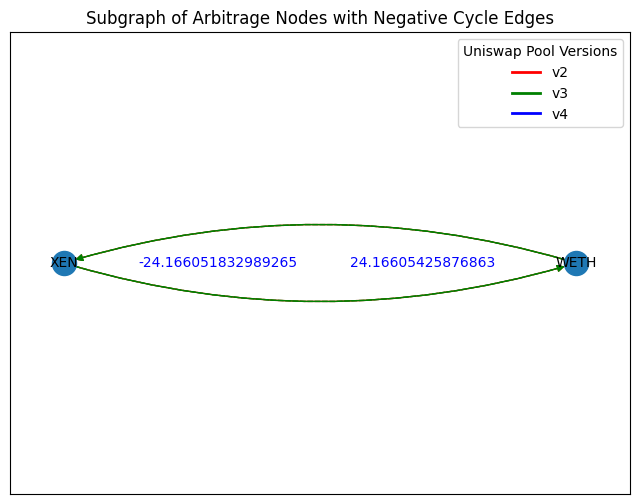

In [22]:
plt.figure(figsize=(8, 6))

# Define colors for each version
version_colors = {'v2': 'red', 'v3': 'green', 'v4': 'blue'}

# Works with arc3 and angle3 connectionstyles
connectionstyle = "arc3,rad=0.15"  # Use a single connection style for all edges

# Get positions for nodes
pos = nx.shell_layout(G_arbt)

# Draw nodes with token_symbol as labels
node_labels = {
    node: df[df['token0_id'] == node]['token0_symbol'].iloc[0] if node in df['token0_id'].values else
          df[df['token1_id'] == node]['token1_symbol'].iloc[0] if node in df['token1_id'].values else 'Unknown'
    for node in G_arbt.nodes()
}
nx.draw_networkx_nodes(G_arbt, pos)
nx.draw_networkx_labels(G_arbt, pos, labels=node_labels, font_size=10)

# Draw edges with colors based on the version attribute and dashed style for negative_cycle_edges
edge_styles = [
    'dashed' if (u, v, k) in negative_cycle_edges else 'solid'
    for u, v, k in G_arbt.edges(keys=True)
]
edge_colors = [
    version_colors[data['version']] if data['version'] in version_colors else 'black'
    for _, _, _, data in G_arbt.edges(keys=True, data=True)
]
nx.draw_networkx_edges(
    G_arbt, pos, edge_color=edge_colors, style=edge_styles, connectionstyle=connectionstyle
)

# Draw edge labels for multiedges
labels = {
    (u, v): f"{data['weight']}"
    for u, v, k, data in G_arbt.edges(keys=True, data=True)
}
nx.draw_networkx_edge_labels(
    G_arbt,
    pos,
    edge_labels=labels,
    label_pos=0.3,
    font_color="blue",
    bbox={"alpha": 0},
)

# Add legend for edge colors
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='v2'),
    plt.Line2D([0], [0], color='green', lw=2, label='v3'),
    plt.Line2D([0], [0], color='blue', lw=2, label='v4'),
]
plt.legend(handles=legend_elements, title="Uniswap Pool Versions", loc='upper right')

plt.title("Subgraph of Arbitrage Nodes with Negative Cycle Edges")
plt.show()
